In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler

## Load data

In [638]:
main = pd.read_csv('Clean_Main.csv')
domviol = pd.read_csv('Clean_DomesticViolence.csv')
subabu = pd.read_csv('Clean_SubstanceAbuse.csv')
unemp = pd.read_csv('Clean_Unemployment_Data.csv')
foodins = pd.read_csv('extrapolated_food_insecure.csv')
pop = pd.read_csv('Clean_Population.csv')

In [639]:
regionmap = pd.read_csv('Region_County_mapping.csv')

In [640]:
main['County'] = main['County'].str.lower()
domviol['County'] = domviol['County'].str.lower()
subabu['County'] = subabu['County'].str.lower()
unemp['County'] = unemp['County'].str.lower()
foodins['County'] = foodins['County'].str.lower()
pop['County'] = pop['County'].str.lower()

domviol['DomesticViolence'] = domviol['DomesticViolence'].str.replace(',','').astype(float)

In [641]:
main.shape

(12149, 10)

## Merge

In [642]:
merged = pd.merge(main,domviol,on=['County','Year'], how='left')

In [643]:
merged.shape

(12149, 11)

In [644]:
merged = pd.merge(merged,subabu,on=['County','Year'], how='left')

In [645]:
merged.shape

(12149, 12)

In [646]:
merged = pd.merge(merged,unemp,on=['County','Year'])

In [647]:
merged.shape

(12149, 13)

In [648]:
merged = pd.merge(merged,foodins,on=['County','Year'])

In [649]:
merged.shape

(12149, 18)

In [650]:
merged = pd.merge(merged,pop,on=['County','Year'])

In [651]:
merged.shape

(12149, 19)

In [652]:
merged.drop(['Area Name','Region','Percent Overweight','Percent Obese','Percent Healthy Weight'],axis=1,inplace=True)

In [653]:
merged = merged[~merged['Percent Overweight or Obese'].isna()]

In [654]:
merged.head()

County  Year  Percent Overweight or Obese  Grade Level     Sex  \
4  allegany  2015                         46.7   ELEMENTARY  FEMALE   
5  allegany  2015                         17.5   ELEMENTARY    MALE   
6  allegany  2015                         64.0  MIDDLE/HIGH  FEMALE   
7  allegany  2015                         28.1  MIDDLE/HIGH    MALE   
8  allegany  2015                         40.6   ELEMENTARY  FEMALE   

   DomesticViolence  Admissions  Unemployment Rate  % Food Insecure  \
4              68.0       313.0              6.533             11.9   
5              68.0       313.0              6.533             11.9   
6              68.0       313.0              6.533             11.9   
7              68.0       313.0              6.533             11.9   
8              68.0       313.0              6.533             11.9   

   Population_x  # Uninsured  # Uninsured.1  Homicide Rate  Population_y  
4       48109.0       3452.0          501.0            NaN       47683.0  
5       48109.0       3452.0          501.0            NaN       47683.0  
6       48109.0       3452.0          501.0            NaN       47683.0  
7       48109.0       3452.0          501.0            NaN       47683.0  
8       48109.0       3452.0          501.0            NaN       47683.0

In [583]:
merged.isna().sum()

County                            0
Year                              0
Percent Overweight or Obese       0
Grade Level                       0
Sex                               0
DomesticViolence                233
Admissions                       59
Unemployment Rate                 0
% Food Insecure                   0
Population_x                   4996
# Uninsured                       0
# Uninsured.1                  4996
Homicide Rate                  6851
Population_y                      0
dtype: int64

## Normalize

In [655]:
merged['DomesticViolence'] = merged['DomesticViolence'].fillna(0) / merged['Population_y']
merged['Admissions'] = merged['Admissions'] / merged['Population_y']
merged['# Uninsured'] = merged['# Uninsured'] / merged['Population_y']
merged['# Uninsured.1'] = merged['# Uninsured.1'] / merged['Population_y']

merged.drop(['Population_y','Population_x'],axis=1, inplace=True)
merged.rename(columns={
    'Percent Overweight or Obese':'OverweightObeseRate',
    'DomesticViolence':'DomesticViolenceRate',
    'Admissions':'SubstanceAbuseAdmissions',
    '% Food Insecure':'FoodInsecurity',
},inplace=True)

In [656]:
merged['SubstanceAbuseAdmissions'].fillna(0,inplace=True)

In [591]:
lat = {
    'albany':42.6526,
    'allegany':42.3130,
    'broome':42.0987,
    'cattaraugus':42.2318,
    'cayuga':42.7655,
    'chautauqua':42.2313,
    'chemung':42.1362,
    'chenango':42.4972,
    'clinton':44.7904,
    'columbia':42.3679,
    'cortland':42.5441,
    'delaware':42.2452,
    'dutchess':41.7784,
    'erie':42.9024,
    'essex':44.0107,
    'franklin':44.5926,
    'fulton':43.1119,
    'genesee':42.9838,
    'greene':42.2957,
    'hamilton':43.4764,
    'herkimer':43.1631,
    'jefferson':44.0607,
    'lewis':43.8401,
    'livingston':42.7577,
    'madison':42.9806,
    'monroe':43.2841,
    'montgomery':42.9155,
    'nassau':40.6546,
    'niagara':43.3119,
    'oneida':43.2372,
    'onondaga':43.0268,
    'ontario':42.8510,
    'orange':41.3912,
    'orleans':43.4089,
    'oswego':43.4825,
    'otsego':42.5780,
    'putnam':41.4351,
    'rensselaer':42.6737,
    'rockland':41.1489,
    'st. lawrence':44.4473,
    'saratoga':43.0324,
    'schenectady':42.8493,
    'schoharie':42.6550,
    'schuyler':42.3796,
    'seneca':42.7652,
    'steuben':42.3210,
    'suffolk':40.9849,
    'sullivan':41.6897,
    'tioga':42.1256,
    'tompkins':42.4576,
    'ulster':41.8586,
    'warren':43.6079,
    'washington':43.2519,
    'wayne':43.2020,
    'westchester':41.1220,
    'wyoming':42.6421,
    'yates':42.6431
}

lon = {
    'albany':73.7562,
    'allegany':78.0195,
    'broome':75.9180,
    'cattaraugus':78.7476,
    'cayuga':76.5488,
    'chautauqua':79.5603,
    'chemung':76.7798,
    'chenango':75.6208,
    'clinton':73.6006,
    'columbia':73.5594,
    'cortland':75.9928,
    'delaware':74.8741,
    'dutchess':73.7478,
    'erie':78.8662,
    'essex':73.9508,
    'franklin':74.3388,
    'fulton':74.4995,
    'genesee':78.1564,
    'greene':74.1240,
    'hamilton':74.4057,
    'herkimer':74.8741,
    'jefferson':75.9928,
    'lewis':75.4345,
    'livingston':77.8367,
    'madison':75.8069,
    'monroe':77.7452,
    'montgomery':74.4526,
    'nassau':73.5594,
    'niagara':78.7476,
    'oneida':75.4345,
    'onondaga':76.1784,
    'ontario':77.2865,
    'orange':74.3118,
    'orleans':78.2020,
    'oswego':76.1784,
    'otsego':75.0611,
    'putnam':73.7949,
    'rensselaer':73.5594,
    'rockland':73.9830,
    'st. lawrence':74.9302,
    'saratoga':73.9360,
    'schenectady':73.9830,
    'schoharie':74.4995,
    'schuyler':76.8721,
    'seneca':76.8721,
    'steuben':77.3784,
    'suffolk':72.6151,
    'sullivan':74.7805,
    'tioga':76.3637,
    'tompkins':76.6488,
    'ulster':74.3118,
    'warren':73.7478,
    'washington':73.3709,
    'wayne':77.0104,
    'westchester':73.7949,
    'wyoming':78.2020,
    'yates':77.1485
    
}

In [592]:
merged['latitude'] = merged.County.map(lat)
merged['longitude'] = merged.County.map(lon)

In [604]:
merged['state'] = "New York"
merged['country'] = "US"

In [596]:
merged['longitude']=merged['longitude']*-1

In [610]:
regionmap = regionmap.iloc[:,:2]
merged_new = pd.merge(merged,regionmap,on='County')

In [629]:
merged_new.groupby('Region').OverweightObeseRate.mean()

Region
Capital          35.982120
Central          37.440487
Finger Lakes     34.768737
Long Island      32.324673
Mid-Hudson       31.606629
Mohawk Valley    36.480292
North Country    41.792632
Southern         38.050367
Western          35.257496
Name: OverweightObeseRate, dtype: float64

In [614]:
merged_new.to_csv('merged_data_raw.csv',index=False)

In [532]:
merged

County  Year  OverweightObeseRate  Grade Level  Sex  \
4      allegany  2015                 46.7            0    0   
5      allegany  2015                 17.5            0    1   
6      allegany  2015                 64.0            1    0   
7      allegany  2015                 28.1            1    1   
8      allegany  2015                 40.6            0    0   
...         ...   ...                  ...          ...  ...   
12144     yates  2016                 39.6            1    1   
12145     yates  2018                 43.3            0    0   
12146     yates  2018                 42.5            0    1   
12147     yates  2018                 32.6            1    0   
12148     yates  2018                 46.8            1    1   

       DomesticViolenceRate  SubstanceAbuseAdmissions  Unemployment Rate  \
4                  0.001426                  0.006564              6.533   
5                  0.001426                  0.006564              6.533   
6                  0.001426                  0.006564              6.533   
7                  0.001426                  0.006564              6.533   
8                  0.001426                  0.006564              6.533   
...                     ...                       ...                ...   
12144              0.003120                  0.007160              4.492   
12145              0.001889                  0.008077              3.742   
12146              0.001889                  0.008077              3.742   
12147              0.001889                  0.008077              3.742   
12148              0.001889                  0.008077              3.742   

       FoodInsecurity  # Uninsured  # Uninsured.1  Homicide Rate  
4                11.9     0.072395       0.010507            NaN  
5                11.9     0.072395       0.010507            NaN  
6                11.9     0.072395       0.010507            NaN  
7                11.9     0.072395       0.010507            NaN  
8                11.9     0.072395       0.010507            NaN  
...               ...          ...            ...            ...  
12144            11.7     0.092440       0.016680            NaN  
12145            11.0     0.056982       0.018646            NaN  
12146            11.0     0.056982       0.018646            NaN  
12147            11.0     0.056982       0.018646            NaN  
12148            11.0     0.056982       0.018646            NaN  

[11199 rows x 12 columns]

## One Hot Encode

In [657]:
merged['Sex'] = merged.Sex.map({'FEMALE':0,'MALE':1})
merged.Sex.dtypes

dtype('int64')

In [658]:
merged['Grade Level'] = merged['Grade Level'].map({'ELEMENTARY':0,'MIDDLE/HIGH':1})
merged['Grade Level'].dtypes

dtype('int64')

## Baseline model

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    merged.drop(['County','Year','OverweightObeseRate','# Uninsured','# Uninsured.1','Homicide Rate'],axis=1), merged['OverweightObeseRate'], test_size=0.33, random_state=42)

In [535]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Decision tree

In [536]:
clf = DecisionTreeRegressor(random_state=0, max_depth=5)
clf.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [537]:
np.sqrt(mean_squared_error(clf.predict(X_train),y_train))

9.504733279070388

In [538]:
mean_absolute_percentage_error(clf.predict(X_train),y_train)

0.19690773370504475

In [539]:
np.sqrt(mean_squared_error(clf.predict(X_test),y_test))

9.316003304849175

In [540]:
mean_absolute_percentage_error(clf.predict(X_test),y_test)

0.19618033971355917

### Random Forest

In [541]:
clf = RandomForestRegressor(max_samples=7000,
                            bootstrap=True,
                            random_state=0, 
                            max_depth=7, 
                            n_estimators=500, 
                            max_features=3, 
                            min_samples_split=100)
clf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features=3, max_samples=7000,
                      min_samples_split=100, n_estimators=500, random_state=0)

In [542]:
np.sqrt(mean_squared_error(clf.predict(X_train),y_train))

9.204478333101846

In [543]:
mean_absolute_percentage_error(clf.predict(X_train),y_train)

0.18896699462214656

In [544]:
np.sqrt(mean_squared_error(clf.predict(X_test),y_test))

9.100278548812017

In [545]:
mean_absolute_percentage_error(clf.predict(X_test),y_test)

0.19107974472393086

### Extra trees

In [546]:
clf = ExtraTreesRegressor(random_state=0, max_depth=7, n_estimators=200, max_features=5)
clf.fit(X_train,y_train)

ExtraTreesRegressor(max_depth=7, max_features=5, n_estimators=200,
                    random_state=0)

In [547]:
np.sqrt(mean_squared_error(clf.predict(X_train),y_train))

9.407672321837007

In [548]:
mean_absolute_percentage_error(clf.predict(X_train),y_train)

0.1932812061046962

In [549]:
np.sqrt(mean_squared_error(clf.predict(X_test),y_test))

9.2999632420403

In [550]:
mean_absolute_percentage_error(clf.predict(X_test),y_test)

0.1955940107509996

### Sid's fav model

In [527]:
clf = xgboost.XGBRegressor(n_estimators=100, max_depth=4, eta=0.089, subsample=0.7, colsample_bytree=0.8)
clf.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.089, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0890000015,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [528]:
np.sqrt(mean_squared_error(clf.predict(X_train),y_train))

9.00746769457805

In [529]:
mean_absolute_percentage_error(clf.predict(X_train),y_train)

0.1859199820579328

In [530]:
np.sqrt(mean_squared_error(clf.predict(X_test),y_test))

9.054411812148716

In [531]:
mean_absolute_percentage_error(clf.predict(X_test),y_test)

0.18993850869886356

### Elastic Net

In [553]:
clf = ElasticNet()
clf.fit(X_train,y_train)

ElasticNet()

In [554]:
np.sqrt(mean_squared_error(clf.predict(X_train),y_train))

10.404393469494368

In [555]:
mean_absolute_percentage_error(clf.predict(X_train),y_train)

0.21614736758168168

In [556]:
np.sqrt(mean_squared_error(clf.predict(X_test),y_test))

10.023663489367143

In [557]:
mean_absolute_percentage_error(clf.predict(X_test),y_test)

0.2125313159296199

## Feature importance

In [659]:
x=merged.drop(['County','Year','OverweightObeseRate','# Uninsured','# Uninsured.1','Homicide Rate'],axis=1)
y=merged['OverweightObeseRate']

clf = RandomForestRegressor(max_samples=7000,
                            bootstrap=True,
                            random_state=0, 
                            max_depth=7, 
                            n_estimators=500, 
                            max_features=3, 
                            min_samples_split=100)
clf.fit(x,y)

RandomForestRegressor(max_depth=7, max_features=3, max_samples=7000,
                      min_samples_split=100, n_estimators=500, random_state=0)

In [660]:
importances = clf.feature_importances_
feature_names = x.columns
sorted_ids = np.argsort(importances)
importances = importances[sorted_ids]
feature_names = feature_names[sorted_ids]

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
std = std[sorted_ids]

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Sex'),
  Text(1, 0, 'SubstanceAbuseAdmissions'),
  Text(2, 0, 'DomesticViolenceRate'),
  Text(3, 0, 'Unemployment Rate'),
  Text(4, 0, 'FoodInsecurity'),
  Text(5, 0, 'Grade Level')])

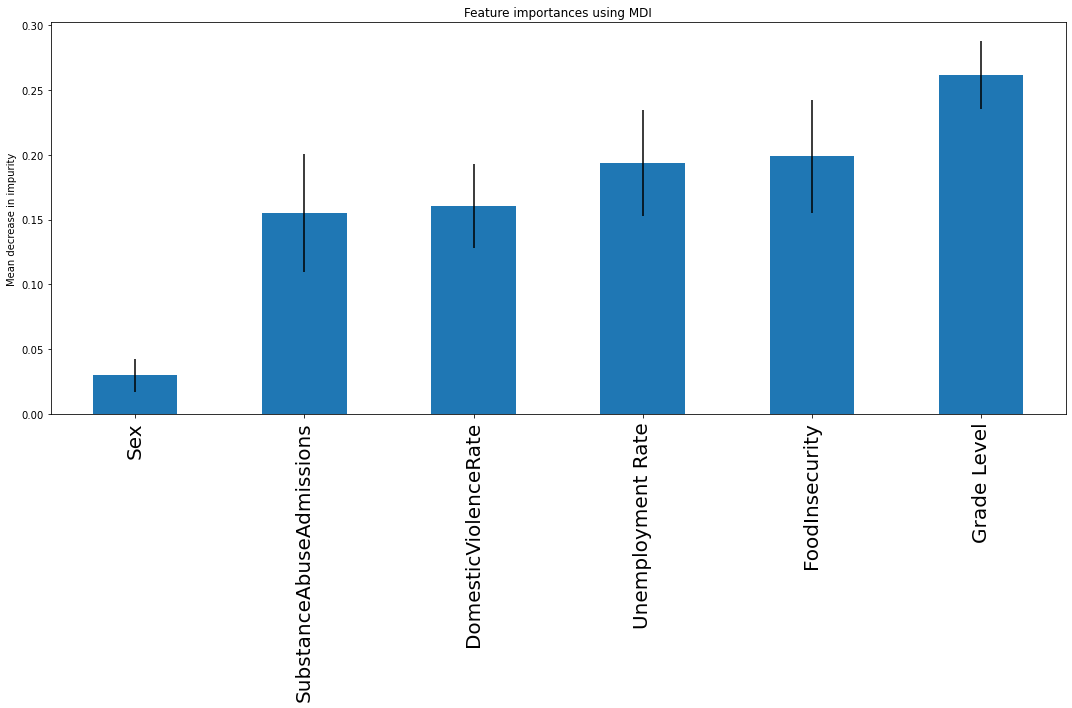

In [662]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.xticks(fontsize=20)

In [564]:
clf = xgboost.XGBRegressor(n_estimators=100, max_depth=4, eta=0.089, subsample=0.7, colsample_bytree=0.8)
clf.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.089, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0890000015,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [565]:
importances = clf.feature_importances_
feature_names = x.columns
sorted_ids = np.argsort(importances)
importances = importances[sorted_ids]
feature_names = feature_names[sorted_ids]

In [566]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [601]:
merged.groupby('County').OverweightObeseRate.mean().sort_values(ascending=False)

County
hamilton        69.787500
essex           44.487963
oswego          43.141463
st. lawrence    42.120761
franklin        41.871074
delaware        41.644512
lewis           41.069231
schoharie       40.972414
chenango        40.635606
jefferson       40.426289
seneca          40.366667
orleans         39.767033
clinton         39.717266
yates           39.711111
sullivan        38.996377
washington      38.920000
greene          38.655914
cortland        38.580220
madison         38.259146
wayne           38.204082
montgomery      37.986047
cattaraugus     37.915238
otsego          37.601064
herkimer        37.459603
tioga           37.458654
warren          37.400000
steuben         37.189474
genesee         37.118881
allegany        36.917742
chemung         36.917308
cayuga          36.885484
livingston      36.591367
wyoming         36.558108
rensselaer      36.517857
ulster          36.507927
chautauqua      36.475884
niagara         36.112778
oneida          35.911538
broom

In [625]:
merged['OverweightObeseRate'].corr(merged['FoodInsecurity'])

0.07871937521666339

In [627]:
merged['OverweightObeseRate'].corr(merged['Unemployment Rate'])

0.11281080808714969